## Image captioning 
inspired and translated into pytorch from https://www.tensorflow.org/tutorials/text/image_captioning


the idea is:
1) encode images with a pretrained model
2) process captions (remove punctuation, tokenization, vectorization)
3) https://arxiv.org/pdf/1502.03044.pdf architecture

In [1]:
#!pip uninstall opencv-python-headless -y
#!pip install opencv-python-headless==4.3.0.38
#!pip install --upgrade pip setuptools wheel
#!pip uninstall fiftyone -y
#!pip install fiftyone==0.14.2 --user
#!pip install git+https://github.com/waleedka/cocoapi.git#egg=pycocotools&subdirectory=PythonAPI
#!pip install torchextractor
#!pip install torchtext==0.11
#!pip install torch==1.10

Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.0/8.0 MB 45.3 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 881.9/881.9 MB 54.1 MB/s eta 0:00:0000:0100:01
  Attempting uninstall: torch
    Found existing installation: torch 1.11.0
    Uninstalling torch-1.11.0:
      Successfully uninstalled torch-1.11.0
  Attempting uninstall: torchtext
    Found existing installation: torchtext 0.12.0
    Uninstalling torchtext-0.12.0:
      Successfully uninstalled torchtext-0.12.0


In [26]:
import torch
from torch.utils.data import Dataset,DataLoader, Subset
from torchvision import transforms
import numpy as np
from PIL import Image
import tqdm
import os

from torch import nn

from pycocotools.coco import COCO

import json
import matplotlib.pyplot as plt


import torch
import re


import torchextractor as tx
import torchtext
from torchtext.data.utils import get_tokenizer


device="cuda:1"
import collections
import random

from torchsummary import summary

from torchtext.vocab import vocab
from typing import Dict, Iterable, Optional, List
from collections import Counter, OrderedDict

In [31]:
def build_vocab_from_iterator(iterator: Iterable, min_freq: int = 1, specials: Optional[List[str]] = None, special_first: bool = True, max_tokens: Optional[int] = None) -> Vocab:
    """
    Build a Vocab from an iterator.

    Args:
        iterator: Iterator used to build Vocab. Must yield list or iterator of tokens.
        min_freq: The minimum frequency needed to include a token in the vocabulary.
        specials: Special symbols to add. The order of supplied tokens will be preserved.
        special_first: Indicates whether to insert symbols at the beginning or at the end.
        max_tokens: If provided, creates the vocab from the `max_tokens - len(specials)` most frequent tokens.


    Returns:
        torchtext.vocab.Vocab: A `Vocab` object

    Examples:
        >>> #generating vocab from text file
        >>> import io
        >>> from torchtext.vocab import build_vocab_from_iterator
        >>> def yield_tokens(file_path):
        >>>     with io.open(file_path, encoding = 'utf-8') as f:
        >>>         for line in f:
        >>>             yield line.strip().split()
        >>> vocab = build_vocab_from_iterator(yield_tokens(file_path), specials=["<unk>"])
    """

    counter = Counter()
    for tokens in iterator:
        counter.update(tokens)

    specials = specials or []



    # First sort by descending frequency, then lexicographically
    sorted_by_freq_tuples = sorted(counter.items(), key=lambda x: (-x[1], x[0]))

    if max_tokens is None:
        ordered_dict = OrderedDict(sorted_by_freq_tuples)
    else:
        assert len(specials) < max_tokens, "len(specials) >= max_tokens, so the vocab will be entirely special tokens."
        ordered_dict = OrderedDict(sorted_by_freq_tuples[:max_tokens - len(specials)])


    if specials is not None:
        if special_first:
            specials = specials[::-1]
        for symbol in specials:
            ordered_dict.update({symbol: min_freq})
            ordered_dict.move_to_end(symbol, last=not special_first)



    word_vocab = vocab(ordered_dict, min_freq=min_freq)
    return word_vocab

In [4]:
class COCOAnnotDataset(Dataset):
    """Face Landmarks dataset."""

    def __init__(self, img_dir, annot_file, transform=None):
        """
        Args:
            csv_file (string): Path to the csv file with annotations.
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.img_dir = img_dir
        self.annot_file = annot_file
        self.transform = transform
        
        self.coco=COCO(annot_file)
        self.indices=self.coco.getAnnIds();

    def __len__(self):
        return len(self.indices)

    def __getitem__(self, idx):
        
        
        #caption
        ann = self.coco.loadAnns(self.indices[idx])[0]
        
        image_id=ann["image_id"]
        
        caption=caption = f"<start> {ann['caption']} <end>"
        
        #image id
        img = self.coco.loadImgs(image_id)[0]
        path=os.path.join(self.img_dir,img["file_name"])
        
        img = Image.open(path).convert('RGB') 
        
        if self.transform:
            img = self.transform(img)

        return img,path,caption

In [5]:
img_dir="/space/matteo/BOLD5000/COCO/val2014"
annot_file='/space/matteo/BOLD5000/COCO/annotations/captions_val2014.json'

preprocess = transforms.Compose([
    transforms.Resize(299),
    transforms.CenterCrop(299),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

train_dataset=COCOAnnotDataset(img_dir,annot_file,transform=preprocess)




loading annotations into memory...
Done (t=0.37s)
creating index...
index created!


In [6]:
x,p,y=next(iter(train_dataset))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


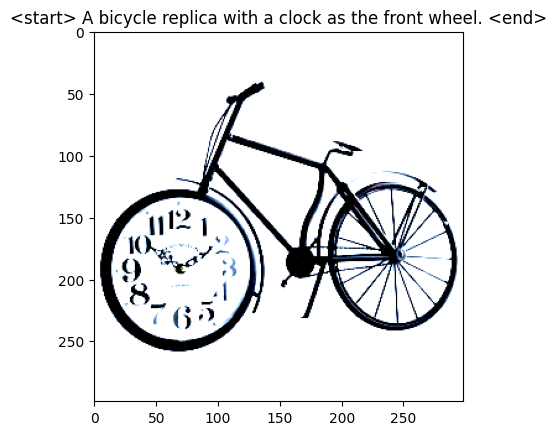

In [7]:
plt.imshow(x.permute(1,2,0))
plt.title(y)

plt.show()

In [8]:
with open(annot_file, 'r') as f:
    annotations = json.load(f)

image_path_to_caption = collections.defaultdict(list)
for val in annotations['annotations']:
    caption = f"<start> {val['caption']} <end>"
    image_path = img_dir + '/COCO_val2014_%012d.jpg' % (val['image_id'])
    image_path_to_caption[image_path].append(caption)
    
    


In [9]:
image_paths = list(image_path_to_caption.keys())
random.shuffle(image_paths)

# Select the first 6000 image_paths from the shuffled set.
# Approximately each image id has 5 captions associated with it, so that will
# lead to 30,000 examples.
train_image_paths = image_paths[:6000]
print(len(train_image_paths))

6000


In [10]:
train_captions = []
img_name_vector = []

for image_path in train_image_paths:
    caption_list = image_path_to_caption[image_path]
    train_captions.extend(caption_list)
    img_name_vector.extend([image_path] * len(caption_list))

## InceptionV3 representations

In [11]:
model = torch.hub.load('pytorch/vision:v0.10.0', 'inception_v3', pretrained=True)
model.eval()

tx.list_module_names(model)
#print("OK")
#model=model.to("cuda")

#summary(model,(3,299,299))

##LAVORARE QUA SCELTA DELLE FEATUES

Using cache found in /home/matteo/.cache/torch/hub/pytorch_vision_v0.10.0


['',
 'Conv2d_1a_3x3',
 'Conv2d_1a_3x3.conv',
 'Conv2d_1a_3x3.bn',
 'Conv2d_2a_3x3',
 'Conv2d_2a_3x3.conv',
 'Conv2d_2a_3x3.bn',
 'Conv2d_2b_3x3',
 'Conv2d_2b_3x3.conv',
 'Conv2d_2b_3x3.bn',
 'maxpool1',
 'Conv2d_3b_1x1',
 'Conv2d_3b_1x1.conv',
 'Conv2d_3b_1x1.bn',
 'Conv2d_4a_3x3',
 'Conv2d_4a_3x3.conv',
 'Conv2d_4a_3x3.bn',
 'maxpool2',
 'Mixed_5b',
 'Mixed_5b.branch1x1',
 'Mixed_5b.branch1x1.conv',
 'Mixed_5b.branch1x1.bn',
 'Mixed_5b.branch5x5_1',
 'Mixed_5b.branch5x5_1.conv',
 'Mixed_5b.branch5x5_1.bn',
 'Mixed_5b.branch5x5_2',
 'Mixed_5b.branch5x5_2.conv',
 'Mixed_5b.branch5x5_2.bn',
 'Mixed_5b.branch3x3dbl_1',
 'Mixed_5b.branch3x3dbl_1.conv',
 'Mixed_5b.branch3x3dbl_1.bn',
 'Mixed_5b.branch3x3dbl_2',
 'Mixed_5b.branch3x3dbl_2.conv',
 'Mixed_5b.branch3x3dbl_2.bn',
 'Mixed_5b.branch3x3dbl_3',
 'Mixed_5b.branch3x3dbl_3.conv',
 'Mixed_5b.branch3x3dbl_3.bn',
 'Mixed_5b.branch_pool',
 'Mixed_5b.branch_pool.conv',
 'Mixed_5b.branch_pool.bn',
 'Mixed_5c',
 'Mixed_5c.branch1x1',
 'Mixed_

In [12]:
model = tx.Extractor(model, ["Mixed_7c"])

model=model.to("cuda:1")



In [20]:
_,feat=model(x.unsqueeze(0).to(device))

In [21]:
print(feat.keys())
feat["Mixed_7c"].shape

dict_keys(['Mixed_7c'])


torch.Size([1, 2048, 8, 8])

### extract features

In [14]:
class ImageDataset(Dataset):

    def __init__(self, img_path_list,transform=None):
        """
        load image
        """
        self.img_path_list = img_path_list
        self.transform = transform
        
    def __len__(self):
        return len(self.img_path_list)

    def __getitem__(self, idx):
        
        
        path=self.img_path_list[idx]
        
        img = Image.open(path).convert('RGB') 
        
        if self.transform:
            img = self.transform(img)

        return img,path

In [15]:
generate_features=True

if generate_features:
    os.makedirs("features",exist_ok=True)
    # Get unique images
    encode_train = sorted(set(img_name_vector))

    # Feel free to change batch_size according to your system configuration
    image_dataset = ImageDataset(encode_train,transform=preprocess)
    image_dataloader = DataLoader(image_dataset,batch_size=128,shuffle=True)

    with torch.no_grad():
        for img, path in tqdm.tqdm(image_dataloader):
            
            _,batch_features = model(img.to(device))
            #print(batch_features["avgpool"].shape)
            batch_features=batch_features["Mixed_7c"].cpu().squeeze().numpy()
            
            for bf, p in zip(batch_features, path):
                
                path_of_feature =os.path.join("features",p.rsplit("/")[-1])
                np.save(path_of_feature, bf)

100%|██████████| 47/47 [02:50<00:00,  3.64s/it]


## head model

1) process caption

In [16]:
def standardize(inputs):
    inputs=inputs.lower()
    return re.sub(r"[!\"#$%&\(\)\*\+.,-/:;=?@\[\\\]^_`{|}~]", "",inputs)
    

In [17]:
train_captions=[standardize(i) for i in train_captions]

'0.11.0'

In [32]:
tokenizer = get_tokenizer('basic_english')

def yield_tokens(data_iter):
    for text in data_iter:
        yield tokenizer(text)

#vocab = torchtext.vocab.build_vocab_from_iterator(yield_tokens(train_captions), specials=["<unk>"],max_tokens=5000)
vocab = build_vocab_from_iterator(yield_tokens(train_captions), specials=["<unk>"],max_tokens=5000)
vocab.set_default_index(vocab["<unk>"])

In [33]:
word_to_index =vocab.get_stoi() 
index_to_word = vocab.get_itos()

In [36]:
cap_vector = [vocab(tokenizer(i)) for i in train_captions]

## train test split data

In [37]:
img_to_cap_vector = collections.defaultdict(list)

In [38]:
for img, cap in zip(img_name_vector, cap_vector):
    img_to_cap_vector[img].append(cap)

In [39]:
# Create training and validation sets using an 80-20 split randomly.
img_keys = list(img_to_cap_vector.keys())
random.shuffle(img_keys)

slice_index = int(len(img_keys)*0.8)
img_name_train_keys, img_name_val_keys = img_keys[:slice_index], img_keys[slice_index:]

img_name_train = []
cap_train = []
for imgt in img_name_train_keys:
    capt_len = len(img_to_cap_vector[imgt])
    img_name_train.extend([imgt] * capt_len)
    cap_train.extend(img_to_cap_vector[imgt])

img_name_val = []
cap_val = []
for imgv in img_name_val_keys:
    capv_len = len(img_to_cap_vector[imgv])
    img_name_val.extend([imgv] * capv_len)
    cap_val.extend(img_to_cap_vector[imgv])


In [40]:
len(img_name_train), len(cap_train), len(img_name_val), len(cap_val)


(24019, 24019, 6006, 6006)

In [41]:
lens=[]
for i in cap_train+cap_val:
    lens.append(len(i))

max_len=np.max(lens)
print(f"Max lenght: {max_len}")

Max lenght: 51


### FeatureCapDataset

In [42]:
class FeatureCaptionDataset(Dataset):

    def __init__(self, img_list,cap_list,max_len=51):
        """
        load image
        """
        self.img_list = img_list
        self.cap_list = cap_list
        self.max_len=max_len
        
    def __len__(self):
        return len(self.img_list)

    def __getitem__(self, idx):
        
        path= "features/"+self.img_list[idx].rsplit("/")[-1]+".npy"
        img_tensor=torch.Tensor(np.load(path,allow_pickle=True))
        cap=self.cap_list[idx]
        cap=torch.Tensor(cap).long()

        ##padding
        # 
        diff=self.max_len-len(cap)
        if diff:
            cap=torch.nn.functional.pad(cap,(0,diff),"constant",cap[-1])

        
        return img_tensor,cap

In [43]:
train_feature_dataset=FeatureCaptionDataset(img_name_train,cap_train,max_len=max_len)
train_features_dataloader=DataLoader(train_feature_dataset,batch_size=16,shuffle=True)


In [44]:
x,y=next(iter(train_feature_dataset))

## Write the model

In [45]:
class BahdanauAttention(nn.Module):

    def __init__(self,units):
        super().__init__()

        self.W1=nn.LazyLinear(units)
        self.W2=nn.LazyLinear(units)
        self.V=nn.LazyLinear(1)

        self.act=nn.Tanh()
        self.softmax=nn.Softmax(dim=1)


    def forward(self,features,hidden):

        #featuresshape (BS, 64,embedding_dim)
        #hidden shape  (BS,hidden_size) -> unsqueeze on dim 1 (time)
        hidden=hidden.unsqueeze(1)
        attention_hidden_layer=self.W1(features)+self.W2(hidden)
        attention_hidden_layer=self.act(attention_hidden_layer)

        #score
        score=self.V(attention_hidden_layer)

  #      print(f"ATTENTION: {attention_hidden_layer.shape} should be (BS,64,units)" )
 #       print(f"SCORE: {score.shape} should be (BS,64,1)")
        

        attention_weigths=self.softmax(score)
        
        context=attention_weigths*features

        context = context.sum(dim=1)

#        print(f"CONTEXT: {context.shape} should be (BS,hidden_size)")


        return context,attention_weigths


In [46]:
class CNNEncoder(nn.Module):

    def __init__(self,embedding_dim):

        """just encode the data"""
        super().__init__()
        self.emb_dim=embedding_dim
        self.lin=nn.LazyLinear(embedding_dim)
        self.act=nn.ReLU()
        #self.model=nn.Sequential(nn.LazyLinear(embedding_dim),nn.ReLU())


    def forward(self,x):
        x=x.reshape(-1,2048,64)
        x=x.transpose(1,2)
        x=self.lin(x)
        x=self.act(x)
        return x

In [47]:
class RNNDecoder(nn.Module):

    def __init__(self,embedding_dim,units,vocab_size):
        super().__init__()

        self.units=units
        self.embedding_dim=embedding_dim
        self.vocab_size=vocab_size

        self.embedding=nn.Embedding(vocab_size,embedding_dim)
        self.gru=nn.GRU(self.units,self.units,batch_first=True)
        self.fc1=nn.LazyLinear(self.units)
        self.fc2=nn.Linear(self.units,self.vocab_size) ##output layer

        self.attention=BahdanauAttention(self.units)
        self.softmax=nn.Softmax()

    def forward(self,x,features,hidden):

        #pay attention on image features
        context,attention_weights=self.attention(features,hidden)

        
        x=self.embedding(x)

        if len(x.shape)==2:
            x=x.unsqueeze(1)


        if len(context.shape)==2:
            context=context.unsqueeze(1)

        #print(f"data, context shapes:  {x.shape,context.shape}")

        x=torch.cat((context,x),dim=-1)

        #print(f"CAT: {x.shape} should be (batch_size,1,embedding_dim+hidden__size)")



        #elaborate signal
        output,state=self.gru(x)

        #print(f"OUT,STATE {output.shape}, {state.shape}")

        x=self.fc1(output)

        #print(f"FC1: {x.shape} should be (batch_size, max_length, hidden_size")


        x=self.fc2(x)
        x=self.softmax(x)

        #print(f"OUTSHAPE: {x.shape} should be (batch_size * max_length, vocab)")

        return x,state,attention_weights
    def reset_state(self,batch_size):
        return torch.zeros((batch_size,self.units))


In [48]:
embedding_dim = 256
units = 512

encoder=CNNEncoder(embedding_dim)
decoder=RNNDecoder(embedding_dim, units, len(word_to_index.keys()))

/home/matteo/anaconda3/envs/pytorch/lib/python3.9/site-packages/torch/nn/modules/lazy.py:178: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


In [49]:

x,y=next(iter(train_features_dataloader))

In [50]:
attention=BahdanauAttention(units)

features=encoder(x)
hidden=decoder.reset_state(batch_size=x.shape[0])
context,attention_weights=attention(features,hidden)

features.shape,hidden.shape

(torch.Size([16, 64, 256]), torch.Size([16, 512]))

## CaptionModel

In [51]:
class CaptionModel(nn.Module):

    """Here the core of the code!"""

    def __init__(self,encoder,decoder,max_len,device=device):
        
        super().__init__()
        self.encoder=encoder
        self.decoder=decoder
        self.max_len=max_len
        self.device=device

    def forward(self,x):
        x=self.encoder(x)
        
        hidden=self.decoder.reset_state(batch_size=x.shape[0]).to(device)
        dec_input=torch.Tensor([word_to_index['<start>']]*x.shape[0]).long().unsqueeze(1).to(self.device)

        attentions=[torch.zeros(16,64,1).to(self.device)]
        captions=[dec_input]
        for i in range(1,self.max_len):
            

            
            predictions,hidden,attn_weights=self.decoder(dec_input,x,hidden)
            captions.append(predictions.argmax(dim=-1))
            attentions.append(attn_weights)
            hidden=hidden.squeeze()

        #reset batch first


        return torch.stack(captions,dim=1),torch.stack(attentions,dim=1)


    def train_step(self,img_tensor,target,criterion,optimizer):

        device=self.device
        optimizer.zero_grad()
        #reset hidden state
        hidden=self.decoder.reset_state(batch_size=target.shape[0]).to(device)

        #input are index of start so BS times index('<start>')
        dec_input=torch.Tensor([word_to_index['<start>']]*target.shape[0]).long().unsqueeze(1).to(device)

        features=self.encoder(img_tensor)
        loss=0


        for i in range(1,target.shape[1]):
            
            #print(f"pass {i} - dec_input {dec_input.shape} hidden {hidden.shape}")
            

            #pass features to decoder

            predictions,hidden,attn_weights=self.decoder(dec_input,features,hidden)

            #print(f"out_hidden: {hidden.shape}")
            #compute loss
            loss+=criterion(predictions.squeeze(),target[:,i])

            #teacher forcing
            hidden=hidden.squeeze()

            dec_input = target[:,i].unsqueeze(1)
            
        
        loss.backward()
        optimizer.step()
        
        total_loss = (loss.item() / int(target.shape[1]))
        
        return loss.item(), total_loss




In [52]:
torch.cuda.empty_cache()
cap_model=CaptionModel(encoder,decoder,max_len=max_len)
cap_model=cap_model.to(device)

In [53]:

captions,attentions=cap_model(x.to(device))
#print(f"Expected: (BS,max_len), (BS,64) got : {captions.shape}, {attentions.shape}")

<ipython-input-47-8f640c47c0d3>:52: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  x=self.softmax(x)


## Optimizer and criterion

In [54]:
criterion=nn.CrossEntropyLoss()
optimizer=torch.optim.Adam(cap_model.parameters(),lr=1e-4)



In [55]:
def train_epoch(model,train_dataloader,criterion,optimizer,device=device):
    loss_tmp=[]
    total_loss=0

    model.train()
    n=0
    for x,y in tqdm.tqdm(train_dataloader):

        x,y=x.to(device),y.to(device)
        loss,t_loss=model.train_step(x,y,criterion=criterion,optimizer=optimizer)
        total_loss+=t_loss
        loss_tmp.append(loss)
        n+=1

    return np.mean(loss_tmp),total_loss/n




In [56]:
EPOCHS=20
loss_history=[]
for epoch in range(EPOCHS):

    ##train 

    loss,total_loss=train_epoch(cap_model,train_dataloader=train_features_dataloader,criterion=criterion,optimizer=optimizer)
    print(f"epoch {epoch+1}/{EPOCHS} loss: {total_loss}")
    loss_history.append(loss)

    torch.save(cap_model.state_dict(),"cap_model.pt")




  0%|          | 0/1502 [00:00<?, ?it/s]<ipython-input-47-8f640c47c0d3>:52: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  x=self.softmax(x)
100%|██████████| 1502/1502 [03:43<00:00,  6.73it/s]


epoch 1/20 loss: 8.338440806313978


100%|██████████| 1502/1502 [03:49<00:00,  6.55it/s]


epoch 2/20 loss: 8.324799019824555


100%|██████████| 1502/1502 [04:03<00:00,  6.16it/s]


epoch 3/20 loss: 8.319367672960635


100%|██████████| 1502/1502 [03:59<00:00,  6.28it/s]


epoch 4/20 loss: 8.31594431437337


100%|██████████| 1502/1502 [03:34<00:00,  7.01it/s]


epoch 5/20 loss: 8.314435120895794


100%|██████████| 1502/1502 [04:12<00:00,  5.94it/s]


epoch 6/20 loss: 8.313124657000934


100%|██████████| 1502/1502 [04:16<00:00,  5.86it/s]


epoch 7/20 loss: 8.311617170232127


100%|██████████| 1502/1502 [04:13<00:00,  5.92it/s]


epoch 8/20 loss: 8.310273698016104


100%|██████████| 1502/1502 [04:21<00:00,  5.75it/s]


epoch 9/20 loss: 8.310377180182604


100%|██████████| 1502/1502 [04:33<00:00,  5.49it/s]


epoch 10/20 loss: 8.308436749526209


100%|██████████| 1502/1502 [03:23<00:00,  7.37it/s]


epoch 11/20 loss: 8.307056836847112


100%|██████████| 1502/1502 [03:25<00:00,  7.31it/s]


epoch 12/20 loss: 8.307110484233215


100%|██████████| 1502/1502 [03:04<00:00,  8.15it/s]


epoch 13/20 loss: 8.306581311292998


100%|██████████| 1502/1502 [03:06<00:00,  8.04it/s]


epoch 14/20 loss: 8.304798980272274


100%|██████████| 1502/1502 [03:08<00:00,  7.97it/s]


epoch 15/20 loss: 8.304924974740093


100%|██████████| 1502/1502 [03:13<00:00,  7.75it/s]


epoch 16/20 loss: 8.304389459807146


100%|██████████| 1502/1502 [03:13<00:00,  7.76it/s]


epoch 17/20 loss: 8.303219565529501


100%|██████████| 1502/1502 [02:49<00:00,  8.86it/s]


epoch 18/20 loss: 8.303457343843805


100%|██████████| 1502/1502 [02:57<00:00,  8.45it/s]


epoch 19/20 loss: 8.302365174533431


100%|██████████| 1502/1502 [02:58<00:00,  8.42it/s]


epoch 20/20 loss: 8.300615636304112


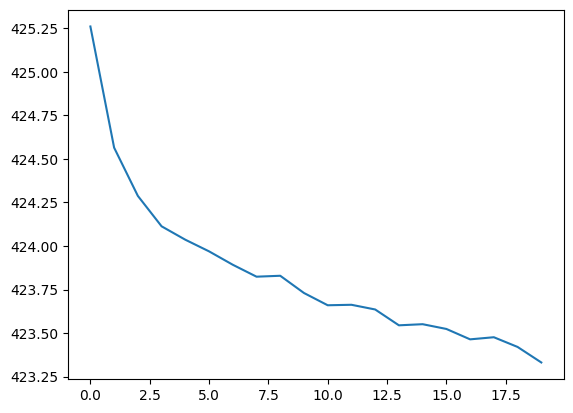

In [58]:
plt.plot(loss_history)
plt.show()

In [59]:
x,y=next(iter(train_features_dataloader))
captions,attentions=cap_model(x.to(device))


captions=captions.squeeze()

<ipython-input-47-8f640c47c0d3>:52: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  x=self.softmax(x)


In [60]:
id=3
y[id],captions[id]

(tensor([   3,   15,  786,  206,  114, 1121,  284,   55,   18,    4,    1,   24,
            2,    2,    2,    2,    2,    2,    2,    2,    2,    2,    2,    2,
            2,    2,    2,    2,    2,    2,    2,    2,    2,    2,    2,    2,
            2,    2,    2,    2,    2,    2,    2,    2,    2,    2,    2,    2,
            2,    2,    2]),
 tensor([3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
         2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
         2, 2, 2], device='cuda:1'))